In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from swarm_sim import *

%matplotlib inline 

In [2]:
NB_NODES = 50
DURATION = 10000   # Nb samples
REVOLUTION = 1800  # Nb samples
SAMPLE_FREQ = 0.1  # Hz
CONNECTION_RANGE = 30000 # m

# Variables globales figures
TMAX = REVOLUTION/SAMPLE_FREQ
IDX = np.arange(0, TMAX, 1/SAMPLE_FREQ) # conversion en secondes

## 1. Formattage des données pour l'analyse
### 1.1 Importation du dataset

In [3]:
PATH = '..\..\data\cnes_swarm50\\track_'
satellites = {}

with tqdm(total=NB_NODES, desc='Extracting data') as pbar:
    for i in range(NB_NODES):
        df = pd.read_csv(PATH+str(i)+'.csv')
        df['coords'] = ['x','y','z']
        satellites[i] = df.set_index('coords', drop=True)
        pbar.update(1)

satellites[0]

Extracting data:   0%|          | 0/50 [00:00<?, ?it/s]

Extracting data: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
coords,,,,,,,,,,,,,,,,,,,,,
x,-4.428846e+05,-4.516533e+05,-4.604007e+05,-4.691266e+05,-4.778306e+05,-4.865122e+05,-4.951711e+05,-5.038068e+05,-5.124189e+05,-5.210071e+05,...,1.440812e+06,1.444147e+06,1.447475e+06,1.450795e+06,1.454108e+06,1.457413e+06,1.460711e+06,1.464001e+06,1.467284e+06,1.470559e+06
y,-7.388676e+05,-7.522884e+05,-7.656739e+05,-7.790237e+05,-7.923370e+05,-8.056132e+05,-8.188518e+05,-8.320520e+05,-8.452134e+05,-8.583352e+05,...,2.329204e+06,2.334225e+06,2.339233e+06,2.344229e+06,2.349213e+06,2.354185e+06,2.359145e+06,2.364092e+06,2.369028e+06,2.373951e+06
z,-2.011435e+06,-2.004528e+06,-1.997528e+06,-1.990435e+06,-1.983248e+06,-1.975968e+06,-1.968596e+06,-1.961132e+06,-1.953577e+06,-1.945930e+06,...,3.661057e+06,3.655167e+06,3.649258e+06,3.643331e+06,3.637384e+06,3.631419e+06,3.625435e+06,3.619433e+06,3.613412e+06,3.607372e+06


### 1.2 Conversion en objet Swarm (module swarm_sim)

In [4]:
swarm_data = {}

with tqdm(total = 2*REVOLUTION, desc = 'Converting to Swarm') as pbar:
    for t in range(2*REVOLUTION):
        swarm_data[t] = Swarm(
            connection_range=CONNECTION_RANGE, 
            nodes=[Node(id, node[str(t)].x, node[str(t)].y, node[str(t)].z) for id,node in satellites.items()]
            )
        pbar.update(1)

print(swarm_data[0])

Converting to Swarm: 100%|██████████| 3600/3600 [00:20<00:00, 172.55it/s]

Swarm of 50 node(s), connection range: 30000


### 1.3 Création de la topologie : établissement des ISL d'après la portée de connexion

In [5]:
with tqdm(total=len(swarm_data.keys()), desc='Neighbor matrix') as pbar:
    for t in swarm_data.keys():
        neighbor_matrix = swarm_data[t].neighbor_matrix()
        pbar.update(1)

Neighbor matrix:   0%|          | 0/3600 [00:00<?, ?it/s]

Neighbor matrix: 100%|██████████| 3600/3600 [00:10<00:00, 344.42it/s]


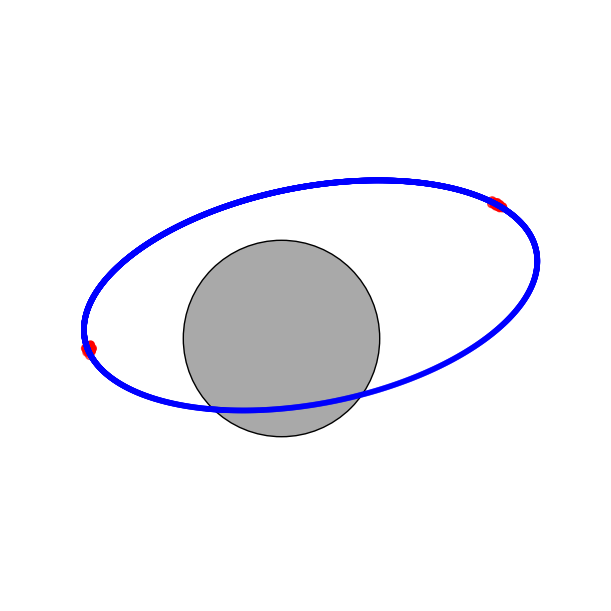

In [6]:
def plot_trajectory(nid, swarm_data, n_color='blue'):
    fig = plt.figure(figsize=(6,6), constrained_layout=True)
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [sw.nodes[nid].x for sw in swarm_data.values()]
    y_data = [sw.nodes[nid].y for sw in swarm_data.values()]
    z_data = [sw.nodes[nid].z for sw in swarm_data.values()]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=10)
    ax.scatter(0,0,0, c='darkgray', edgecolor='black', s=20000)
    for t in (200,1100):
        ax.scatter([node.x for node in swarm_data[t].nodes], 
                   [node.y for node in swarm_data[t].nodes], 
                   [node.z for node in swarm_data[t].nodes], 
                   c='red', 
                   s=30)
    
plot_trajectory(0, swarm_data)

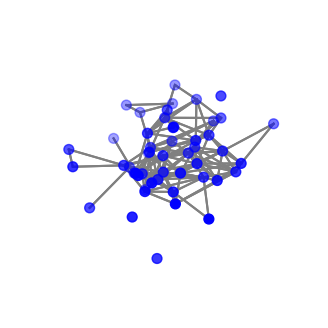

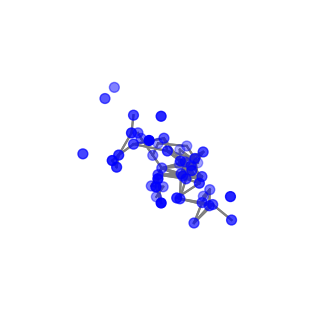

In [7]:
def plot_edges(swarm, n_color='blue', e_color='gray'):
    fig = plt.figure(figsize=(4,4))
    ax = plt.axes(projection='3d')
    ax.set_axis_off()
    x_data = [node.x for node in swarm.nodes]
    y_data = [node.y for node in swarm.nodes]
    z_data = [node.z for node in swarm.nodes]
    ax.scatter(x_data, y_data, z_data, c=n_color, s=50)
    for node in swarm.nodes:
        for n in node.neighbors:
            if n in swarm.nodes:
                ax.plot([node.x, n.x], [node.y, n.y], [node.z, n.z], c=e_color)
                
plot_edges(swarm_data[200])
plot_edges(swarm_data[1100])

## 2. Propriétés du réseau
### 2.1 Mobilité
Vitesse de déplacement de l'essaim

In [8]:
def compute_velocity(sw1, sw2):
    return [n1.compute_dist(n2)*SAMPLE_FREQ for (n1,n2) in zip(sw1.nodes, sw2.nodes)]

swarm_velocity = [np.mean(compute_velocity(swarm_data[t], swarm_data[t+1])) for t in range(REVOLUTION)]
avg_swarm_velocity = np.mean(swarm_velocity)
print('Vitesse de déplacement moyenne de l\'essaim :', np.round(avg_swarm_velocity,2), 'm/s soit', np.round(avg_swarm_velocity*3.6,2), 'km/h')
print('Vitesse min :', np.round(min(swarm_velocity),2), 'm/s soit', np.round(min(swarm_velocity)*3.6,2), 'km/h')
print('Vitesse max :', np.round(max(swarm_velocity),2), 'm/s soit', np.round(max(swarm_velocity)*3.6,2), 'km/h')

Vitesse de déplacement moyenne de l'essaim : 1160.59 m/s soit 4178.13 km/h
Vitesse min : 821.04 m/s soit 2955.75 km/h
Vitesse max : 1748.06 m/s soit 6293.03 km/h


In [72]:
# Distance par rapport à la Lune (pour comparaison)
def compute_moon_dist(sw):
    moon = Node(-1, x=0, y=0, z=0)
    return [moon.compute_dist(n) for n in sw.nodes]

moon_dist = [np.mean(compute_moon_dist(swarm_data[t])) for t in range(REVOLUTION)]
moon_dist_km = [e/1000 for e in moon_dist]

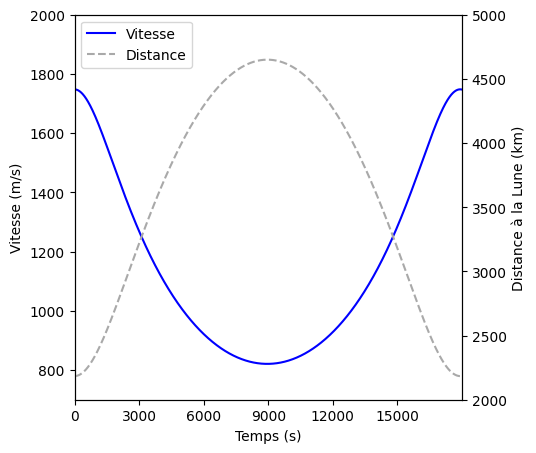

In [77]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, swarm_velocity, c='blue', label='Vitesse')
#l2 = ax.hlines(avg_swarm_velocity, 0, TMAX, ls='--', color='red', label='Vitesse moyenne')
ax.set_xlim(0, TMAX)
ax.set_ylim(700,2000)
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Vitesse (m/s)')
ax.set_xticks(np.arange(0, TMAX, 3000))

ax2 = ax.twinx()
l3 = ax2.plot(IDX, moon_dist_km, c='darkgray', ls='--', label='Distance')
ax2.set_ylim(2000,5000)
ax2.set_ylabel('Distance à la Lune (km)')

lns = l1 + l3
labels = [l.get_label() for l in lns]
ax.legend(lns, labels, loc='upper left')

Analyse des distances inter-satellites

In [78]:
def compute_distance_matrix(swarm_chunk):
    distance_matrix = {}
    with tqdm(total=REVOLUTION, desc='Computing Distance matrix') as pbar:
        for t in range(REVOLUTION):
            distance_matrix[t] = swarm_chunk[t].distance_matrix()
            pbar.update(1)
    return distance_matrix

dm = compute_distance_matrix(swarm_data)
avg_distances_time = [np.mean(dm_time) for dm_time in dm.values()]

Computing Distance matrix: 100%|██████████| 1800/1800 [00:01<00:00, 947.15it/s]


In [79]:
T_HIGH = 75
T_AVG = 656
T_LOW = 1520

Text(0, 0.5, 'Distance (m)')

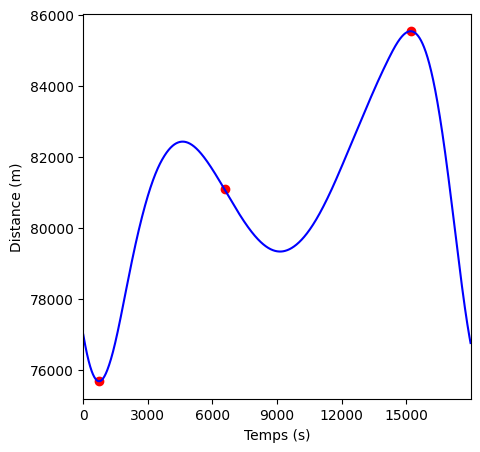

In [80]:
fig, ax = plt.subplots(figsize=(5,5))

l1 = ax.plot(IDX, avg_distances_time, c='blue', label='Inter-satellite')
ax.scatter([T_HIGH/SAMPLE_FREQ, T_AVG/SAMPLE_FREQ, T_LOW/SAMPLE_FREQ], 
            [avg_distances_time[T_HIGH],
             avg_distances_time[T_AVG],
             avg_distances_time[T_LOW]],
            c='red')
ax.set_xlim(0,TMAX)
ax.set_xticks(np.arange(0, TMAX, 3000))
ax.set_xlabel('Temps (s)')
ax.set_ylabel('Distance (m)')

Niveaux de densité caractéristiques d'après la distance inter-satellites moyenne :
 - t=75 (750 s) : densité forte
 - t=656 (6560 s) : densité moyenne
 - t=1520 (15200 s) : densité faible

In [53]:
distrib_distances = {}
distrib_distances[T_LOW] = [e for row in dm[T_LOW] for e in row]
distrib_distances[T_AVG] = [e for row in dm[T_AVG] for e in row]
distrib_distances[T_HIGH] = [e for row in dm[T_HIGH] for e in row]

(0.0, 320000.0)

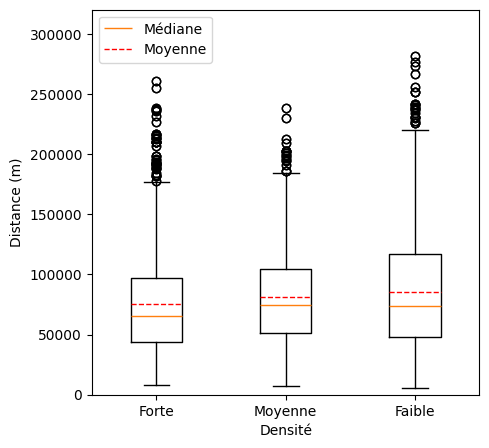

In [84]:
fig,ax = plt.subplots(figsize=(5,5))

bp = ax.boxplot([distrib_distances[T_HIGH],
                 distrib_distances[T_AVG],
                 distrib_distances[T_LOW]], 
            vert=True, 
            widths=0.4,
            meanline=True, 
            showmeans=True, 
            meanprops={'color':'red','ls':'--'}
            )
ax.legend([bp['medians'][0], bp['means'][0]], ['Médiane', 'Moyenne'], loc='upper left')
ax.set_xticklabels(['Forte','Moyenne','Faible'])
ax.set_xlabel('Densité')
ax.set_ylabel('Distance (m)')
ax.set_ylim(0,320000)

In [55]:
np.mean(avg_distances_time)

81047.84308428463